In [1]:
import cv2
from matplotlib import patches
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray
import sys
sys.path.insert(0,'..')
import utils

In [2]:
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

In [9]:
slide_image = "../TIFs/trainingTIFs/tumor_091.tif"
mask_image = "../TIFs/trainingTIFs/tumor_091_mask.tif"
slide = open_slide(slide_image)
mask = open_slide(mask_image)

In [10]:
slide.level_dimensions

((61440, 53760),
 (30720, 26880),
 (15360, 13440),
 (7680, 6720),
 (3840, 3360),
 (1920, 1680),
 (960, 840),
 (480, 420))

In [11]:
slide_level4 = read_slide(slide, 0, 0, 4, slide.level_dimensions[4][0], slide.level_dimensions[4][1])
slide_level5 = read_slide(slide, 0, 0, 5, slide.level_dimensions[5][0], slide.level_dimensions[5][1])

In [12]:
print(slide_level4.shape)
print(slide_level5.shape)

(3360, 3840, 3)
(1680, 1920, 3)


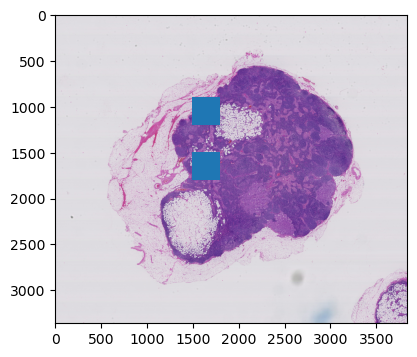

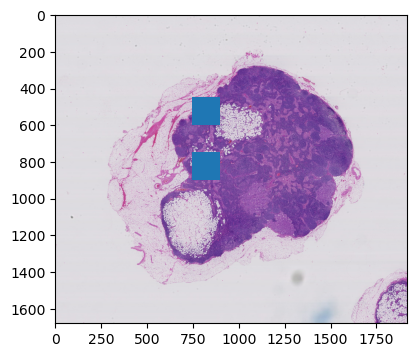

In [13]:
plt.figure(figsize=(10, 10))
ax1 = plt.subplot(121)
ax1.imshow(slide_level4)
rect1 = patches.Rectangle(xy=(299*5, 299*3), width=299, height=299)
rect2 = patches.Rectangle(xy=(299*5, 299*5), width=299, height=299)
ax1.add_patch(rect1)
ax1.add_patch(rect2)
plt.show()

# the higher the level, the more zoomed-out
# fig, ax = plt.subplots(figsize=(5, 5))
plt.figure(figsize=(10, 10))
ax2 = plt.subplot(122)
ax2.imshow(slide_level5)
rect1 = patches.Rectangle(xy=(299*5//2, 299*3//2), width=299//2, height=299//2)
rect2 = patches.Rectangle(xy=(299*5//2, 299*5//2), width=299//2, height=299//2)
ax2.add_patch(rect1)
ax2.add_patch(rect2)
plt.show()

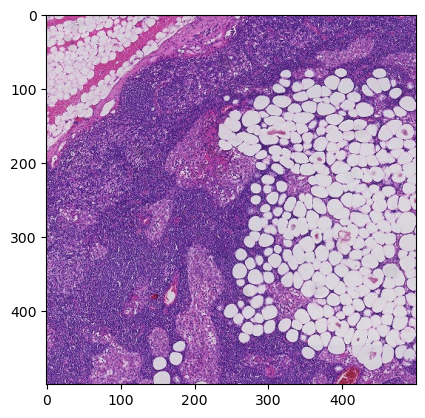

In [7]:
slide_level4_sample = read_slide(slide, 299*5*2**4, 299*3*2**4, 4, 500, 500)
plt.imshow(slide_level4_sample)

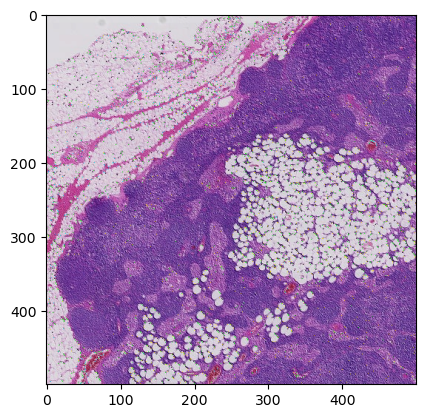

In [8]:
slide_level5_sample = read_slide(slide, (299*5*2**5-250*2**5)//2, (299*3*2**5-250*2**5)//2, 5, 500, 500)
plt.imshow(slide_level5_sample)

In [9]:
# As mentioned in class, we can improve efficiency by ignoring non-tissue areas 
# of the slide. We'll find these by looking for all gray regions.
def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return list(zip(indices[0], indices[1]))

# tissue_pixels = find_tissue_pixels(slide_image)
# percent_tissue = len(tissue_pixels) / float(slide_image.shape[0] * slide_image.shape[0]) * 100
# print ("%d tissue_pixels pixels (%.1f percent of the image)" % (len(tissue_pixels), percent_tissue)) 

def apply_mask(im, mask, color=(255,0,0)):
    masked = np.copy(im)
    for x,y in mask: masked[x][y] = color
    return masked


def cal_tissue_perc(image, intensity=0.8):
    tissue_pixels = find_tissue_pixels(image)
    return len(tissue_pixels) / float(image.shape[0] * image.shape[0]) * 100

suppose I want to get two patches at different zoom levels centered at the same 
place

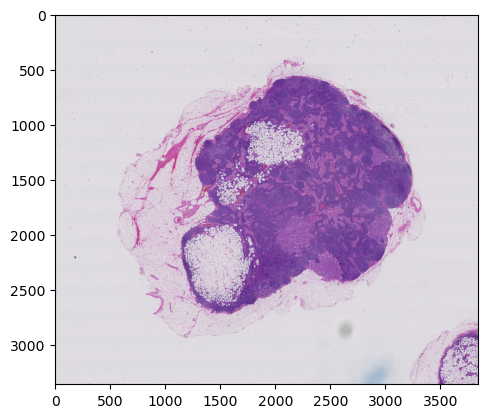

In [16]:
plt.imshow(slide_level4)

In [21]:
print(slide_level4.shape)

(3360, 3840, 3)


(1680, 1920, 3)


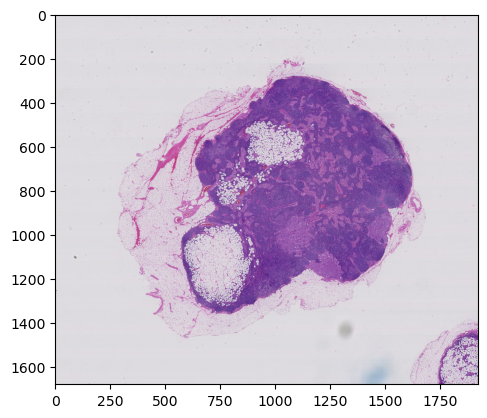

In [22]:
plt.imshow(slide_level5)
print(slide_level5.shape)

2855 4627
(299, 299, 3)
(299, 299, 3)


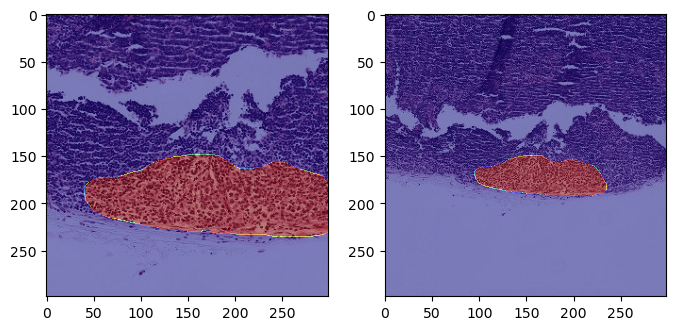

In [62]:
# the downsample factor at level 4 and 5
level3_downsample_fac = int(slide.level_downsamples[3])
level4_downsample_fac = int(slide.level_downsamples[4])

center_x_level3, center_y_level3 = 6008, 9553 # x,y are w.r.t. computer vision
patchsize_level3 = 299

patchsize_level4 = patchsize_level3

start_x_level3 = center_x_level3 - patchsize_level3 // 2
start_y_level3 = center_y_level3 - patchsize_level3 // 2

start_x_level30 = start_x_level3 * level3_downsample_fac
start_y_level30 = start_y_level3 * level3_downsample_fac

center_x_level4 = center_x_level3 * level3_downsample_fac // level4_downsample_fac
center_y_level4 = center_y_level3 * level3_downsample_fac // level4_downsample_fac

start_x_level4 = center_x_level4 - patchsize_level4 // 2
start_y_level4 = center_y_level4 - patchsize_level4 // 2

# the starting point w.r.t. level 0
start_x_level40 = start_x_level4 * level4_downsample_fac
start_y_level40 = start_y_level4 * level4_downsample_fac

print(start_x_level4, start_y_level4)

# make patches
# 1. the patch size must be the same -> have to feed into the model
level_3_patch = read_slide(slide, start_x_level30, start_y_level30, 3, patchsize_level3, patchsize_level3)
level_4_patch = read_slide(slide, start_x_level40, start_y_level40, 4, patchsize_level4, patchsize_level4)
level3_mask = read_slide(mask, start_x_level30, start_y_level30, 3, patchsize_level3, patchsize_level3)[:,:,0]
level4_mask = read_slide(mask, start_x_level40, start_y_level40, 4, patchsize_level4, patchsize_level4)[:,:,0]

print(level_3_patch.shape)
print(level_4_patch.shape)

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].imshow(level_3_patch)
axs[0].imshow(level3_mask, cmap="jet", alpha=0.5)
axs[1].imshow(level_4_patch)
axs[1].imshow(level4_mask, cmap="jet", alpha=0.5)

plt.savefig("test.png")

In [61]:
level3_mask = utils.read_entire_slide(mask, 3)[:,:,0]
tumor_indices = np.transpose(np.where(level3_mask == 1))

i, j = tumor_indices[0]
print(i, j)

9553 6008


In [12]:
slide_level4.shape

(3360, 3840, 3)

In [13]:
slide_level5.shape

(1680, 1920, 3)

In [14]:
slide.level_downsamples

(1.0, 2.0, 4.0, 8.0, 16.0, 32.0, 64.0, 128.0)

500 500 300 300 700 700
400
patch level 4 shape: (400, 400, 3)
patch level 5 shape: (400, 400, 3)


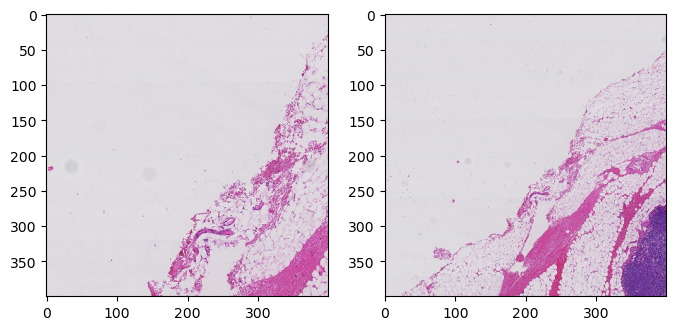

In [15]:
# the center of the coordinate at level 4
# those are chosen by me
center_x_level4, center_y_level4 = 1000, 1000

# the size of the patch at level 4
# chosen by me
patchsize_level4 = 400

# the size of patch at level 5, needs 
# to be the same as size at level 4
patchsize_level5 = patchsize_level4

# =============================
# =starting point 4->0=========
# the starting point at level 4
start_x_level4 = center_x_level4 - patchsize_level4 // 2
start_y_level4 = center_y_level4 - patchsize_level4 // 2
end_x_level4 = start_x_level4 + patchsize_level4
end_y_level4 = start_y_level4 + patchsize_level4

# # the starting point w.r.t. level 0
# start_x_level40 = start_x_level4 * level4_downsample_fac
# start_y_level40 = start_y_level4 * level4_downsample_fac

# =============================
# =starting point 5->0=========
center_x_level5 = center_x_level4 * level4_downsample_fac // level5_downsample_fac # /2
center_y_level5 = center_y_level4 * level4_downsample_fac // level5_downsample_fac

start_x_level5 = center_x_level5 - patchsize_level5 // 2
start_y_level5 = center_y_level5 - patchsize_level5 // 2
end_x_level5 = start_x_level5 + patchsize_level5
end_y_level5 = start_y_level5 + patchsize_level5

print(center_x_level5, center_y_level5, start_x_level5, start_y_level5, end_x_level5, end_y_level5)
# # the starting point w.r.t. level 0
# start_x_level50 = start_x_level5 * level5_downsample_fac
# start_y_level50 = start_y_level5 * level5_downsample_fac

patch_level4 = slide_level4[start_y_level4:end_y_level4, start_x_level4:end_y_level4]
patch_level5 = slide_level5[start_y_level5:end_y_level5, start_x_level5:end_y_level5]

print(f"{end_y_level4 - start_y_level4}")
print(f"patch level 4 shape: {patch_level4.shape}")
print(f"patch level 5 shape: {patch_level5.shape}")

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].imshow(slide_level4[start_y_level4:end_y_level4, start_x_level4:end_y_level4])
axs[1].imshow(slide_level5[start_y_level5:end_y_level5, start_x_level5:end_y_level5])

In [63]:
a = np.array([
    [1, 2, 3],
    [2, 3, 4],
    [3, 4, 5]
])
b = np.random.choice(3, 3, replace=False)
print(b)
a[b]

[2 0 1]


array([[3, 4, 5],
       [1, 2, 3],
       [2, 3, 4]])

In [69]:
a = np.array([
    [1, 2],
    [2, 3],
    [3, 4]
])
a

array([[1, 2],
       [2, 3],
       [3, 4]])

In [75]:
a[:,0]

array([1, 2, 3])

In [77]:
rows = np.where((a[:,0]>1) & (a[:,1]<4))
a[rows]

array([[2, 3]])

In [68]:
a[len(a)//4::2]

array([2, 4, 6, 8])